In [32]:
%matplotlib inline

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model



# Load and prepare the data

In [33]:
X_load = np.load('../data/processed_data/m4015_session2/X_serial.npy')
Y_load = np.load('../data/processed_data/m4015_session2/y_serial.npy')

n_hidden=1000

In [34]:
print(np.sum(Y_load) / len(Y_load))

0.020211432474913946


In [35]:
res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

In [36]:
def save_model(model, save_dir='models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    t = time.strftime("%Y%m%d-%H:%M:%S")
    path = os.path.join(save_dir, t+'.h5')  
    model.save(path)

    
def generator(X, y, batch_size, lookback):
    batch_features = np.zeros((batch_size, lookback, 1))
    batch_labels = np.zeros((batch_size, lookback, 2))
    batch_weights = np.zeros((batch_size, lookback))
    while True:
        for i in range(batch_size):
            while True:
                index = np.random.randint(0, X.shape[0]-lookback)
                a = X[index:index+lookback]
                batch_features[i] = np.reshape(a, (a.shape[0], -1))
                batch_labels[i] = y[index:index+lookback]
                batch_weights[i] = y[index:index+lookback,0]*1. + y[index:index+lookback,1]*50
                if np.sum(batch_features[i])<0:
                    break
        yield batch_features, batch_labels, batch_weights

In [37]:
train_generator = generator(X_load[:90000], Y_load[:90000,:], 100, n_hidden)
validate_generator = generator(X_load[90000:], Y_load[90000:,:], 100, n_hidden)

In [38]:
n_dim = 1
input_shape = (None,n_dim)
batch_size = n_hidden

keras.backend.clear_session()
inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(inputs)
x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(x)
x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(loss=['categorical_crossentropy'],
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'],
              sample_weight_mode='temporal')


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           202       
Total params: 201,802
Trainable params: 201,802
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=5, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=100,
                              )

save_model(model)

Epoch 1/5
100/100 [==============================] - 802s 8s/step - loss: 1.2937 - acc: 0.8441 - val_loss: 1.3878 - val_acc: 0.9801
Epoch 2/5
 57/100 [================>.............] - ETA: 5:11 - loss: 1.2836 - acc: 0.9445

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
X, y, w = next(validate_generator)
res = model.predict(X)

In [ ]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

second_dir = 'real'
save_dir = os.path.join(save_dir, second_dir)  
if not os.path.exists(save_dir):
        os.makedirs(save_dir)


for i in range(res.shape[0]):
# for i in range(50):
    path = os.path.join(save_dir, str(i)+'.pdf')  
    plt.figure()
    plt.plot(X[i], lw=2, label='estimator')
    plt.plot(np.argmax(res[i], axis=1)-8, lw=2, label='estimator')
    plt.plot(np.argmax(y[i], axis=1)-8, lw=2, label='truth')
    plt.ylim(-10., 10.)
    plt.legend()
    plt.savefig(path)
    plt.close()

In [12]:
X_load = np.load('../data/processed_data/m4015_session2/X_serial.npy')
Y_load = np.load('../data/processed_data/m4015_session2/y_serial.npy')

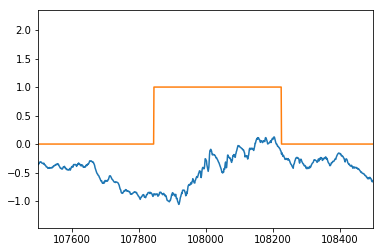

In [30]:
plt.figure()
plt.plot(X_load)
plt.plot(Y_load)
plt.xlim(107500, 108500)
plt.show()

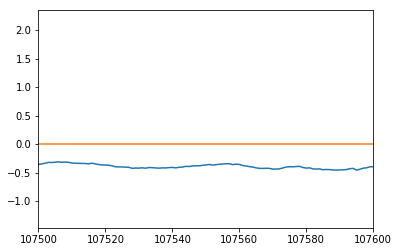